# Model Performance Evaluation
In this notebook we seek to evaluate the performance of different models using a range of different metrics. The most basic of which are Punzi scans, predicted probability distributions, Kolmogrov-Smirnov tests and ROC curves.

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
from joblib import load
#import xgboost as xgb # Still broken...
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [4]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

version = '7.0.2'
train = df = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = df = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = df = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

In [5]:
nn_model = tf.keras.models.load_model(f'../neural_network/models/v{version}')
knn_model = load(f'../classification_methods/models/KNN_{version}.joblib')
rfc_model = load(f'../classification_methods/models/RFC_{version}.joblib')
dtc_model = load(f'../classification_methods/models/DTC_{version}.joblib')
# CURRENTLY BROKEN
#my_xgb_model = xgb.XGBClassifier()
#my_xgb_model.load_model(f"../classification_methods/models/XGB_{version}.json")

my_models = [nn_model, knn_model, rfc_model, dtc_model]
my_model_names = ['NN', 'KNN', 'RFC', 'DTC']

2022-03-11 09:52:50.314778: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 09:52:50.320790: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Predicted Probability Distributions

In [6]:
# Generate all the predictions
test_preds = [np.squeeze(nn_model.predict(X_test))]
train_preds = [np.squeeze(nn_model.predict(X_train))]
for model in my_models[1:]:
    test_preds.append(model.predict_proba(X_test)[:,1])
    train_preds.append(model.predict_proba(X_train)[:,1])

2022-03-11 09:53:44.564196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-11 09:53:44.582761: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


In [7]:
# Make histograms for each model
bins = np.linspace(0, 1, 41)
bin_width = bins[1] - bins[0]
hs = []

for pred_set in test_preds:
    h, _ = np.histogram(pred_set, bins=bins)
    hs.append(h)

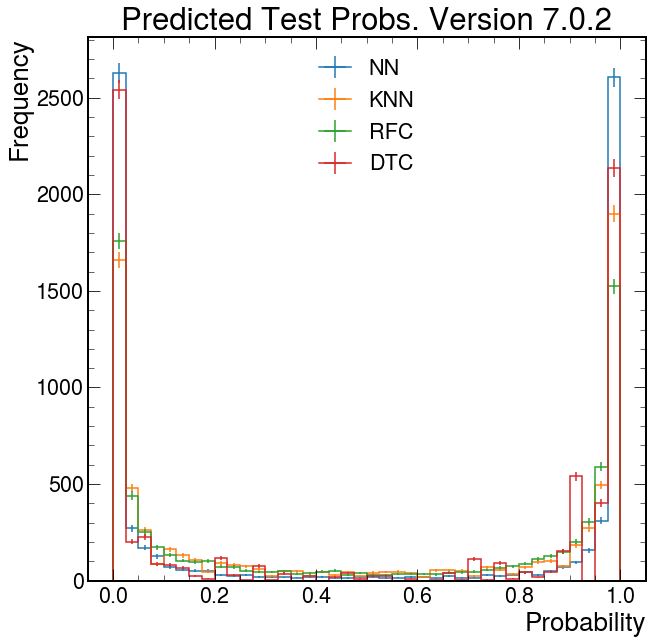

In [8]:
fig, ax = plt.subplots(1, 1)
hep.histplot(hs, bins=bins, yerr=[np.sqrt(i) for i in hs], ax=ax, label=my_model_names)
plt.ylabel('Frequency')
plt.xlabel('Probability')
plt.legend(loc='upper center')
plt.title(f'Predicted Test Probs. Version {version}')
plt.savefig(f'../images/ModelEval/Pred_Prob_Dist_{version}.png', dpi=800)
plt.show()

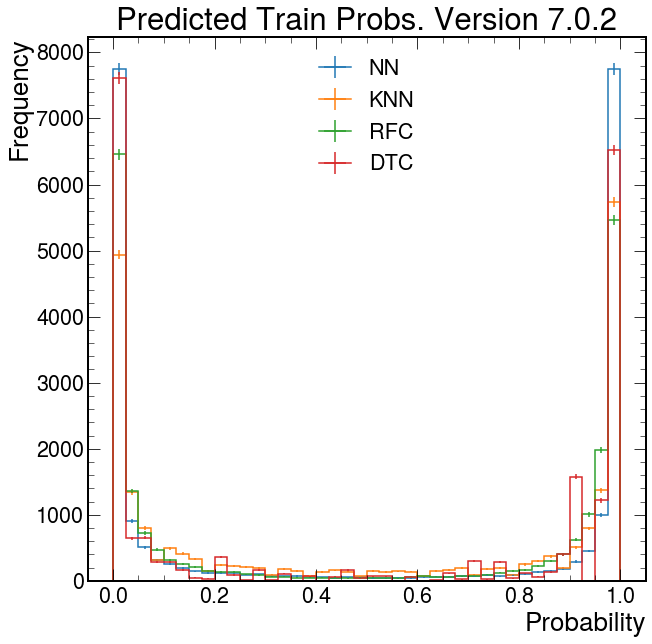

In [9]:
hs2 = []

for pred_set in train_preds:
    h, _ = np.histogram(pred_set, bins=bins)
    hs2.append(h)

fig, ax = plt.subplots(1, 1)
hep.histplot(hs2, bins=bins, yerr=[np.sqrt(i) for i in hs2], ax=ax, label=my_model_names)
plt.ylabel('Frequency')
plt.xlabel('Probability')
plt.legend(loc='upper center')
plt.title(f'Predicted Train Probs. Version {version}')
plt.savefig(f'../images/ModelEval/Pred_Prob_Dist_{version}.png', dpi=800)
plt.show()

## ROC Curves

In [10]:
roc_test_data, roc_train_data = [], []

for i, m in enumerate(test_preds):
    roc_test_data.append(roc_curve(test['category'], m))
    roc_train_data.append(roc_curve(train['category'], train_preds[i]))

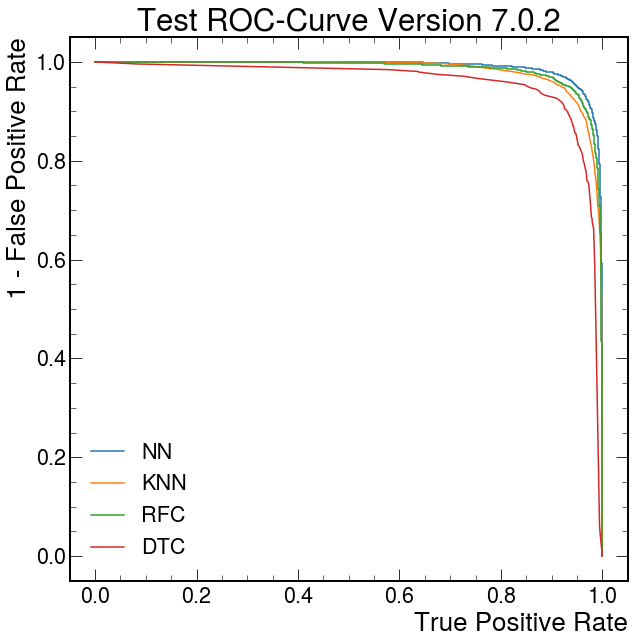

In [13]:
fig, ax = plt.subplots(1, 1)

for i, j in enumerate(roc_test_data):
    ax.plot(j[1], 1-j[0], label=my_model_names[i])

plt.ylabel('1 - False Positive Rate')
plt.xlabel('True Positive Rate')
plt.legend(loc='lower left')
plt.title(f'Test ROC-Curve Version {version}')
plt.savefig(f'../images/ModelEval/Test_ROC_{version}.png', dpi=800)
plt.show()

Models perform all exceedingly well. If there is any overfitting it is very minimal and not influencing these models ability to generalise to unseen test data. We should also plot the ROC curves for each model in the test versus the train instance and look for any discrepancies (this would indicate overtraining).

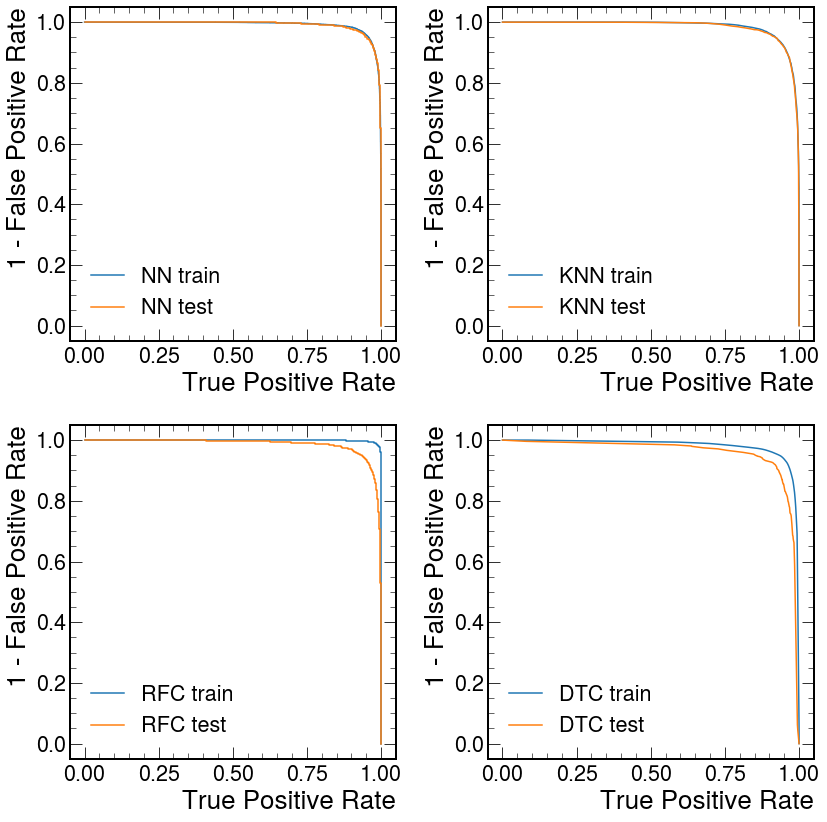

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

m = 0
n = 0

for i, value in enumerate(roc_train_data):
    if i == 2:
        m += 1
    ax[m][n].plot(value[1], 1-value[0], label=f'{my_model_names[i]} train')
    ax[m][n].plot(roc_test_data[i][1], 1-roc_test_data[i][0], label=f'{my_model_names[i]} test')
    ax[m][n].legend()
    ax[m][n].legend()
    ax[m][n].set_ylabel('1 - False Positive Rate')
    ax[m][n].set_xlabel('True Positive Rate')
    
    n += 1
    if n == 2:
        n = 0

plt.tight_layout()
plt.savefig(f'../images/ModelEval/TestvsTrain_ROC_{version}.png', dpi=800)
plt.show()

Well the XGB model is very overtrained. The others are not at all overtrained...maybe we need to a find a better XGB model!

In [ ]:
# Calculate the purities...
# purity = no of signal events / all events selected
train_purity = 

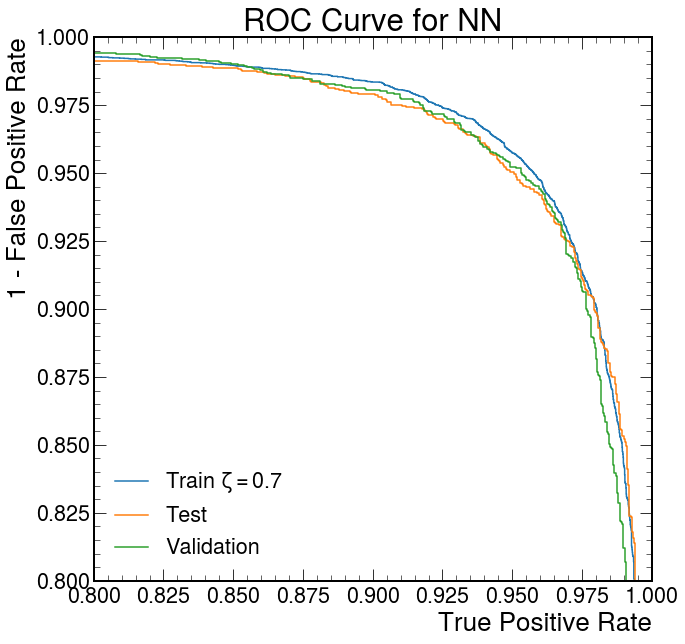

In [39]:
val_roc = roc_curve(y_val, nn_model.predict(X_val).flatten())

fig, ax = plt.subplots(1, 1)

ax.plot(roc_train_data[0][1], 1-roc_train_data[0][0], label='Train $\zeta=0.7$')
ax.plot(roc_test_data[0][1], 1-roc_test_data[0][0], label=f'Test')
ax.plot(val_roc[1], 1-val_roc[0], label=f'Validation')
ax.set_xlim(0.8, 1)
ax.set_ylim(0.8, 1)

plt.ylabel('1 - False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for NN')
plt.legend(loc='lower left')
#plt.savefig('../images/ModelEval/NN_7.0.2_ROC.png', dpi=800)
plt.show()

## ROC-AUC & Accuracy Scores

In [40]:
print(f"Neural Network\nROC-AUC: {roc_auc_score(y_test, test_preds[0])}\nAccuracy Score: {accuracy_score(y_test, np.where(test_preds[0]>0.5,1,0))}\n")
print(f"KNN\nROC-AUC: {roc_auc_score(y_test, test_preds[1])}\nAccuracy Score: {accuracy_score(y_test, np.where(test_preds[1]>0.5,1,0))}\n")
print(f"RFC\nROC-AUC: {roc_auc_score(y_test, test_preds[2])}\nAccuracy Score: {accuracy_score(y_test, np.where(test_preds[2]>0.5,1,0))}\n")
print(f"DTC\nROC-AUC: {roc_auc_score(y_test, test_preds[3])}\nAccuracy Score: {accuracy_score(y_test, np.where(test_preds[3]>0.5,1,0))}")

Neural Network
ROC-AUC: 0.9903286160547572
Accuracy Score: 0.9499862599615279

KNN
ROC-AUC: 0.9833495509844058
Accuracy Score: 0.9334982137949986

RFC
ROC-AUC: 0.9854581854581855
Accuracy Score: 0.9435284418796372

DTC
ROC-AUC: 0.9590515449436611
Accuracy Score: 0.9182467710909591


## Kolmogorov-Smirnov Goodness-of-Fit Test
How similar are two underlying distributions? We test this with the KS-test. We want the predicted probability distributions for the train, validation and test data to be very similar. If this is the case then there is no evidence of overfitting.

In [28]:
from scipy.stats import ks_2samp

In [29]:
# XGB Model
ks1, p1 = ks_2samp(all_test_prob_preds[0], all_train_prob_preds[0])

# Neural Network Model
ks2, p2 = ks_2samp(all_test_prob_preds[1], all_train_prob_preds[1])

# KNN Model
ks3, p3 = ks_2samp(all_test_prob_preds[2], all_train_prob_preds[2])

NameError: name 'all_test_prob_preds' is not defined

In [ ]:
print(f"XGB Model\nKS: {ks1:.4f}\nP-Value: {p1:.6f}\n")
print(f"NN Model\nKS: {ks2:.4f}\nP-Value: {p2:.6f}\n")
print(f"KNN Model\nKS: {ks3:.4f}\nP-Value: {p3:.6f}\n")

XGB Model
KS: 0.0321
P-Value: 0.000026

NN Model
KS: 0.0094
P-Value: 0.710713

KNN Model
KS: 0.0081
P-Value: 0.860418



Again similar analysis shows there is no large overfitting in either dataset with respect to the predicted probability distributions. This is because the very small KS statistic value implies the null hypothesis (F(x)=G(x)) cannot be rejected.

## Punzi Scan

In [ ]:
def calculate_punzi(preds, labelled_data, prob_range=[0.3, 0.98], dpoints=150, significance=5, mass_range=[5200, 5800]):    
    probability_space = np.linspace(prob_range[0], prob_range[1], dpoints)
    # A region over which the Punzi FOM will be calculated
    
    labels = labelled_data['category'].to_numpy()
    nsignal_before = labelled_data['category'].value_counts()[1]
    # How many signal events are in the original data sample
    
    punzis = []
    for p in probability_space:
        # Iterate through each point in probability space
        
        # Each event is predicted a probability P. If P < p we say that,
        # it is background, else it is signal. I.e. p -> 1 in limit of high
        # background rejection, high purity sample 
        
        ps = np.squeeze(np.where(preds < p, 0, 1))
        all = np.array([ps, labels]).T
        
        efficiency = len(np.squeeze(np.where((all == [1, 1]).all(axis=1)))) / nsignal_before
        # Truth matched signal i.e. model said it was signal and it actually was 
        background = np.squeeze(np.where((all == [1, 0]).all(axis=1)))
        try:
            background = background.shape[0]
        except:
            background = 0
        # background you thought was signal, so did not reject i.e. it got through 
        
        #print(f'{p:.4f} {efficiency:.5f} {background}')
        # Background is how much background is left after the cut i.e. how much REAL background is left (incorrectly identified as signal)
        
        punzi = efficiency / (significance/2 + np.sqrt(background))
        # Calculate the Punzi as defined by LHCb 
        
        punzis.append(punzi)
        # Add this point to the array of Punzis
    return np.array(punzis), probability_space

In [ ]:
xgb_punzi_values, xgb_pspace = calculate_punzi(all_test_prob_preds[0], test, dpoints=300)
nn_punzi_values, nn_pspace = calculate_punzi(all_test_prob_preds[1], test, dpoints=300)
knn_punzi_values, knn_pspace = calculate_punzi(all_test_prob_preds[2], test, dpoints=300)

xgb_punzi_values1, xgb_pspace1 = calculate_punzi(all_train_prob_preds[0], train, dpoints=300)
nn_punzi_values1, nn_pspace1 = calculate_punzi(all_train_prob_preds[1], train, dpoints=300)
knn_punzi_values1, knn_pspace1 = calculate_punzi(all_train_prob_preds[2], train, dpoints=300)

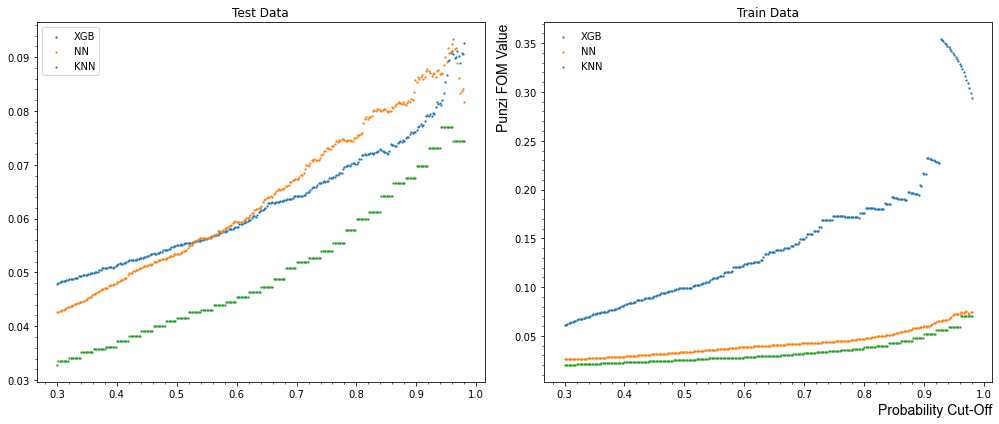

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('#FFFFFF')
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].scatter(xgb_pspace, xgb_punzi_values, label='XGB', s=1.5)
ax[0].scatter(nn_pspace, nn_punzi_values, label='NN', s=1.5)
ax[0].scatter(knn_pspace, knn_punzi_values, label='KNN', s=1.5)
ax[0].set_title('Test Data')

ax[1].scatter(xgb_pspace1, xgb_punzi_values1, label='XGB', s=1.5)
ax[1].scatter(nn_pspace1, nn_punzi_values1, label='NN', s=1.5)
ax[1].scatter(knn_pspace1, knn_punzi_values1, label='KNN', s=1.5)
ax[1].set_title('Train Data')

ax[0].legend()
ax[1].legend()

plt.ylabel('Punzi FOM Value', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
plt.xlabel('Probability Cut-Off', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
plt.legend(loc='upper left', ncol=1, fancybox=False, shadow=True, frameon=False)
plt.tight_layout()
plt.show()

From the look of these Punzi plots we are safe to take a cut position of about 0.85. This should provide excellent purity of signal and reduction of background with the drawback of some signal being potentially lost.

## Binary Accuracy Evaluation

## SHAP Values